### Loading the Packages

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers,losses
from tensorflow.keras.models import Model


### Loading the dataset

In [ ]:
# Download the dataset
dataframe = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv', header=None)
raw_data = dataframe.values
dataframe.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0


In [ ]:
labels = raw_data[:, -1]
data = raw_data[:,0:-1]
train_data,test_data,train_labels,test_labels= train_test_split(
    data,labels,test_size=0.2,random_state=21
)

### Data Normalization (min_max_scaling)

In [ ]:
min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)

train_data = (train_data - min_val) / (max_val-min_val)
test_data = (test_data-min_val)/(max_val-min_val)
train_data = tf.cast(train_data,tf.float32)
test_data = tf.cast(test_data,tf.float32)

In [ ]:
train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

normal_train_data = train_data [train_labels]
normal_test_data = test_data[test_labels]

anomalous_train_data = train_data[~train_labels]
anomalous_test_data = test_data [~test_labels]
anomalous_test_data

array([[-1.2347339e+00, -2.0763535e+00, -2.6428473e+00, ...,
         1.7306776e+00,  1.4677791e+00,  1.5545514e+00],
       [-3.3769023e-03, -2.7926539e-01, -2.3051899e-01, ...,
        -2.2283731e+00, -1.8375444e+00, -3.7848925e-01],
       [-1.5695109e+00, -1.9828811e+00, -1.8390784e+00, ...,
        -1.7463882e+00, -1.0677629e+00, -5.0527311e-02],
       ...,
       [-1.5008938e+00, -2.3655078e+00, -2.3063070e+00, ...,
        -1.9158444e+00, -1.5414373e+00, -9.4956009e-02],
       [ 1.5375483e+00,  1.4332603e+00,  8.9591029e-01, ...,
        -4.5176859e+00, -3.8148065e+00, -2.6285849e+00],
       [ 1.4626735e-01,  3.9611411e-02,  3.4571825e-02, ...,
         1.6561895e+00,  1.8883270e+00,  1.9757517e+00]])

### Plot a normal ECG

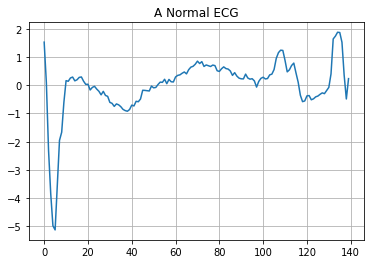

In [ ]:
plt.grid()
plt.plot(np.arange(140),normal_train_data[0])
plt.title("A Normal ECG")
plt.show()

### Plot an anomalous ECG

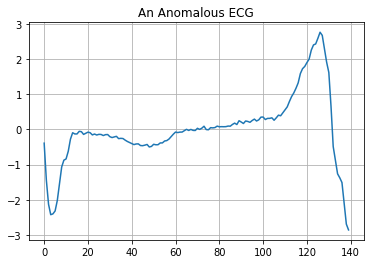

In [ ]:
plt.grid()
plt.plot(np.arange(140),anomalous_train_data[0])
plt.title("An Anomalous ECG")
plt.show()

### Model Architecture

In [ ]:
class AnomalyDetector(Model):
    def __init__(self):
        super(AnomalyDetector,self).__init__()
        self.encoder = tf.keras.Sequential([
            layers.Dense(32,activation="relu"),
            layers.Dense(16,activation="relu"),
            layers.Dense(8,activation="relu")
        ])
        self.decoder = tf.keras.Sequential([
            layers.Dense(16,activation="relu"),
            layers.Dense(32,activation="relu"),
            layers.Dense(140,activation="sigmoid")
        ])
    def call(self,x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
autoencoder = AnomalyDetector()

In [ ]:
autoencoder.compile(optimizer = 'adam',loss='mae')

### Model Training

In [ ]:
history = autoencoder.fit(normal_train_data,normal_train_data,
                          epochs=20,
                          batch_size=512,
                          validation_data = (test_data,test_data),
                          shuffle=True)

Epoch 1/20
5/5 [==============================] - 2s 94ms/step - loss: 0.7648 - val_loss: 0.7125
Epoch 2/20
5/5 [==============================] - 0s 40ms/step - loss: 0.7601 - val_loss: 0.7075
Epoch 3/20
5/5 [==============================] - 0s 35ms/step - loss: 0.7497 - val_loss: 0.6974
Epoch 4/20
5/5 [==============================] - 0s 30ms/step - loss: 0.7302 - val_loss: 0.6805
Epoch 5/20
5/5 [==============================] - 0s 23ms/step - loss: 0.6995 - val_loss: 0.6564
Epoch 6/20
5/5 [==============================] - 0s 26ms/step - loss: 0.6597 - val_loss: 0.6281
Epoch 7/20
5/5 [==============================] - 0s 19ms/step - loss: 0.6167 - val_loss: 0.6001
Epoch 8/20
5/5 [==============================] - 0s 24ms/step - loss: 0.5785 - val_loss: 0.5787
Epoch 9/20
5/5 [==============================] - 0s 31ms/step - loss: 0.5510 - val_loss: 0.5644
Epoch 10/20
5/5 [==============================] - 0s 17ms/step - loss: 0.5325 - val_loss: 0.5544
Epoch 11/20
5/5 [============

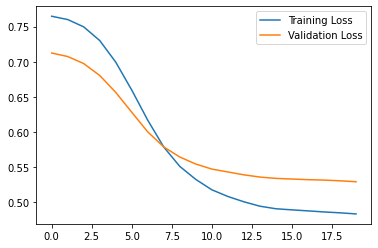

In [ ]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

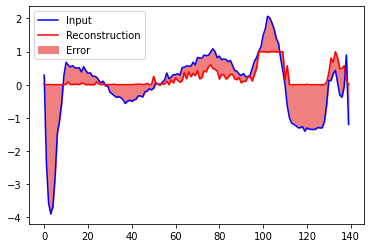

In [ ]:
encoded_data = autoencoder.encoder(normal_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(normal_test_data[0],'b')
plt.plot(decoded_data[0],'r')
plt.fill_between(np.arange(140),decoded_data[0],normal_test_data[0],color='lightcoral')
plt.legend(labels = ["Input","Reconstruction","Error"])
plt.show()

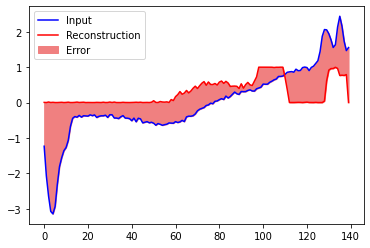

In [ ]:
encoded_data = autoencoder.encoder(anomalous_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(anomalous_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(140), decoded_data[0], anomalous_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

### Anomaly detection

#### Plot the reconstruction error on normal ECGs

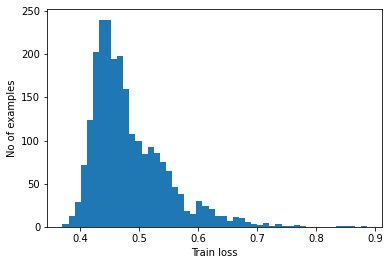

In [ ]:
reconstructions = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions,normal_train_data)

plt.hist(train_loss[None,:],bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

#### Plot the reconstruction error on anomalous data

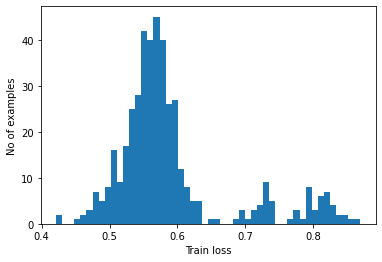

In [ ]:
reconstructions = autoencoder.predict(anomalous_test_data)
train_loss = tf.keras.losses.mae(reconstructions,anomalous_test_data)

plt.hist(train_loss[None,:],bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

#### Setting a threshold

In [ ]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold : ",threshold)

Threshold :  0.5457142625792459


#### Performance metrics

In [ ]:
def predict(model, data, threshold):
  reconstructions = model(data)
  loss = tf.keras.losses.mae(reconstructions, data)
  return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
  print("Accuracy = {}".format(accuracy_score(labels, predictions)))
  print("Precision = {}".format(precision_score(labels, predictions)))
  print("Recall = {}".format(recall_score(labels, predictions)))

In [ ]:
preds = predict(autoencoder, test_data, threshold)
print_stats(preds, test_labels)

Accuracy = 0.798
Precision = 0.7973421926910299
Recall = 0.8571428571428571
